<a href="https://colab.research.google.com/github/CharFox1/CompVisProj/blob/main/lstmCharModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn, tensor
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision.transforms as T
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!unzip handwrittenChars.zip

Archive:  handwrittenChars.zip
   creating: handwrittenChars/
   creating: handwrittenChars/.ipynb_checkpoints/
  inflating: handwrittenChars/.ipynb_checkpoints/parseHandwrittenChars-checkpoint.ipynb  
  inflating: handwrittenChars/parseHandwrittenChars.ipynb  
  inflating: handwrittenChars/trainSmall.npy  
  inflating: handwrittenChars/valSmall.npy  


In [3]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [39]:
# Manually pick cpu device if desired
device = "cpu"

In [4]:
# resnet block to be used in models below
# code modified from "resnet-34-pytorch-starter-kit"

class resBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1, kernel_size=3, padding=1, bias=False):
    super(resBlock, self).__init__()
    
    self.cnn1 = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(True)
    )

    self.cnn2 = nn.Sequential(
        nn.Conv2d(out_channels, out_channels, kernel_size, 1, padding, bias=False),
        nn.BatchNorm2d(out_channels)
    )

    # if the output image will be a different size than the input
    # must reshape residual to fit new output shape
    if stride != 1 or in_channels != out_channels:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(out_channels)
      )
    # otherwise just pass it through 
    else:
      self.shortcut = nn.Sequential()

  def forward(self, x):
    residual = x
    x = self.cnn1(x)
    x = self.cnn2(x)
    x += self.shortcut(residual)
    x = nn.ReLU(True)(x)
    return x

In [5]:
# small function to turn int index into one hot encoding
def oneHot(num, numClasses):
  output = [0] * numClasses
  output[num] = 1
  return output

training data size: 78000
validation data size: 13209
training data shape: (32, 32)


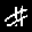

data type of image = <class 'numpy.ndarray'>
training data label: #
each index in dataset has image (32x32) and char label
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [6]:
# get conv demo data (https://www.kaggle.com/vaibhao/handwritten-characters)
from google.colab.patches import cv2_imshow #allows us to show images

# grab small files (created from larger dataset)
# this is the location they should be in the github
# if you are running in collab, you need to import the handwrittenChars folder as a zip
# you can unzip it with "!unzip handwrittenChars.zip" in a separate cell
with open("handwrittenChars/trainSmall.npy", "rb") as f:
    conv_train_data = np.load(f, allow_pickle=True)

with open("handwrittenChars/valSmall.npy", "rb") as f:
    conv_val_data = np.load(f, allow_pickle=True)

print("training data size:", len(conv_train_data))
print("validation data size:", len(conv_val_data))

print("training data shape:", conv_train_data[1201][0].shape)
cv2_imshow(conv_train_data[1201][0])
print("data type of image =", type(conv_train_data[1201][0]))
print("training data label:", conv_train_data[1201][1])
print("each index in dataset has image (32x32) and char label")
print(conv_train_data[1201][0])

In [7]:
labels = []
# used for stopping prediction of recurrent layers
labels.append("<EOS>") 
for i in conv_train_data:
  label = i[1]
  if label not in labels:
    labels.append(label)

print("there are", len(labels), "labels in the training dataset")

for i in conv_val_data:
  label = i[1]
  if label not in labels:
    labels.append(label)

print("there are", len(labels), "labels in the validation dataset")

labelDict = {}
for i in range(len(labels)):
  labelDict[i] = labels[i]

print(labelDict)
invertedLabelDict = {y:x for x,y in labelDict.items()}
print(invertedLabelDict)

there are 40 labels in the training dataset
there are 40 labels in the validation dataset
{0: '<EOS>', 1: '#', 2: '$', 3: '&', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: '@', 15: 'A', 16: 'B', 17: 'C', 18: 'D', 19: 'E', 20: 'F', 21: 'G', 22: 'H', 23: 'I', 24: 'J', 25: 'K', 26: 'L', 27: 'M', 28: 'N', 29: 'P', 30: 'Q', 31: 'R', 32: 'S', 33: 'T', 34: 'U', 35: 'V', 36: 'W', 37: 'X', 38: 'Y', 39: 'Z'}
{'<EOS>': 0, '#': 1, '$': 2, '&': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, '@': 14, 'A': 15, 'B': 16, 'C': 17, 'D': 18, 'E': 19, 'F': 20, 'G': 21, 'H': 22, 'I': 23, 'J': 24, 'K': 25, 'L': 26, 'M': 27, 'N': 28, 'P': 29, 'Q': 30, 'R': 31, 'S': 32, 'T': 33, 'U': 34, 'V': 35, 'W': 36, 'X': 37, 'Y': 38, 'Z': 39}


In [8]:
# dataset class
class handwrittenCharsDataset(Dataset):
    def __init__(self, X, classToNum):
      self.classToNum = classToNum
      self.images = []
      self.labels = []
      for i in X:
        self.images.append(i[0])
        self.labels.append(i[1])

    def __len__(self):
      return len(self.labels)

    def __getitem__(self, index):
      image = self.images[index]
      # since lstm is being used but there is always only 1 char, no need to worry about parsing label
      # just make one hot vector for char and end token and put them together in tensor
      char = self.classToNum[self.labels[index]]
      end = self.classToNum["<EOS>"]
      label = tensor([char, end])
      image = self.transform(image)
      sample = [image, label]
      return sample

    transform = T.Compose([
      T.ToPILImage(),
      T.ToTensor()                     
    ])

In [9]:
batch_size = 10
dataset = handwrittenCharsDataset(X=conv_train_data, classToNum=invertedLabelDict)
train_dl = DataLoader(dataset, batch_size, shuffle=True, pin_memory=True)

In [11]:
def toChars(nums, dict):
  out = []
  for num in nums:
    out.append(dict[num])
  return out

In [64]:
# recurrent conv model to look at image and predict chars until all are read
# uses resnet structure

class convLSTM(nn.Module):
  def __init__(self, numClasses, maxLength, batchSize):
    super(convLSTM, self).__init__()
    self.numClasses = numClasses
    self.maxLength = maxLength
    self.batchSize = batchSize

    self.block1 = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=2, stride=2, padding=3, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True)
    )

    self.block2 = nn.Sequential(
        nn.MaxPool2d(1, 1),
        resBlock(64, 64),
        resBlock(64, 64, 2)
    )

    self.block3 = nn.Sequential(
        resBlock(64, 128),
        resBlock(128, 128, 2)
    )

    self.block4 = nn.Sequential(
        resBlock(128, 256),
        resBlock(256, 256, 2)
    )

    self.block5 = nn.Sequential(
        resBlock(256, 512),
        resBlock(512, 512, 2)
    )

    self.avgpool = nn.AvgPool2d(2)
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(512, 512)
    self.l2 = nn.Linear(512, 256)
    self.l3 = nn.Linear(256, numClasses)
    # input size, hidden size, num layers
    self.lstm = nn.LSTMCell(256, 256)

  def forward(self, x):
    # resnet layers
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.block5(x)
    x = self.avgpool(x)
    x = self.flatten(x)
    
    # recurrent an supporting layers
    x = self.l1(x)
    x = self.l2(x)
    
    # give lstm compressed version of image and previous value
    x = x.reshape(1, 256)

    # for as many characters as is allowed, predict a char from image and from previous hidden values 
    sequence = []
    # init hidden and cell vectors to 0s
    h = torch.zeros(1, 256).to(device)
    c = torch.zeros(1, 256).to(device)
    for i in range(self.maxLength):
      h, c = self.lstm(x, (h, c))

      # use last layer to turn sequence to numClasses width so it can be considered
      # probability distribution over classes (a prediction)
      out = self.l3(h)
      sequence.append(out)

    # turn list of predictions into a tensor and return
    final = torch.stack(sequence, dim=0)
    #print(final)
    return final

In [73]:
def parsePred(pred):
  pred = pred.detach().cpu().numpy()
  #print(pred)
  out = []
  for i in pred:
    #print(i)
    out.append(labelDict[i[0].argmax(0).item()])

  return "".join(out)

Feature batch shape: torch.Size([10, 1, 32, 32])
Labels batch shape: torch.Size([10, 2])
test label: [20  0]


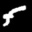

predicted @@@@@ for F<EOS>


In [82]:
# init model with 40 classes on output layer
# max length description of image of 5 chars
# batch size = 10
# put model in gpu if available
LSTMModel = convLSTM(40, 5, 10).to(device)
#print(convModel)

testItem, testLabel = next(iter(train_dl))
print(f"Feature batch shape: {testItem.size()}")
print(f"Labels batch shape: {testLabel.size()}")

testItem = testItem[0].unsqueeze(0).to(device)
#testLabel = labelDict[testLabel[0].numpy().argmax()]
testLabel = testLabel.numpy()[0]
print("test label:", testLabel)

# some funny business to get image from tensor to see if guess is reasonable
image = testItem[0].cpu().numpy()[0] * 255
cv2_imshow(image)


# predict 
output = LSTMModel(testItem)

# turn prediction sequence into chars
y_pred = parsePred(output)
print("predicted", y_pred,  "for", "".join(toChars(testLabel, labelDict)))

In [60]:
def findAccuracy(outputs, labels):
  accuracy = 0
  for i in range(len(outputs)):
    if outputs[i].cpu().detach().numpy().argmax() == labels[i]:
      accuracy += 1

  return (accuracy/len(outputs))


In [88]:
import torch.optim as optim
LSTMModel = convLSTM(40).to(device)

lossFunc = nn.CrossEntropyLoss()
opt = optim.SGD(LSTMModel.parameters(), lr=0.001) 

num_epochs = 10
max_len = 2
batch_size = 10

testLoss = []
testAcc = []

for epoch in range(num_epochs):
  running_loss = 0
  running_acc = 0
  for i, data in enumerate(train_dl, 0):
    pred = []
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    
    opt.zero_grad()
    hidden = LSTMModel.initHidden(10)

    done = False 
    while not done:
      outputs, hidden = LSTMModel(images, hidden)
      pred += outputs
      #print(outputs[0][0])
      for out in outputs[0]:
        if labelDict[out.argmax(0).item()] == "<EOS>":
          done = True
    
    loss = lossFunc(pred, labels)
    loss.backward()
    opt.step()

    running_acc += findAccuracy(outputs, labels)

    running_loss += loss.item()
    if i % 1000 == 999:
      testLoss.append(running_loss)
      testAcc.append(running_acc/10)
      print("[%d, %5d] loss: %.5f acc: %.3f%%" % (epoch + 1, i + 1, running_loss / 1000, running_acc / 10))
      running_loss = 0
      running_acc = 0

print("Done!")

AttributeError: ignored